## Домашнее задание

Взять с прошлого домашнего задания ряд (в двух вариантах - стационарный и нет) и приблизить оба эти варианта моделями из класса MA. Оценить качество и прислать соображения почему была выбрана та или иная модель.

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt
from scipy.stats import boxcox
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [24]:
# Dickey-Fuller test
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
#     print(dfoutput)
    return dfoutput['p-value']

In [22]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
#     test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
        plt.show()
    return

**Будем рассматривать временной ряд `*International airline passengers: monthly totals in thousands***`

In [7]:
# prepairing data
airlines_passengers = pd.read_csv("Series/international-airline-passengers.csv")

all_series = {
    "International airline passengers: monthly totals in thousands": airlines_passengers["Count"]
}

**Нестационарный ряд**

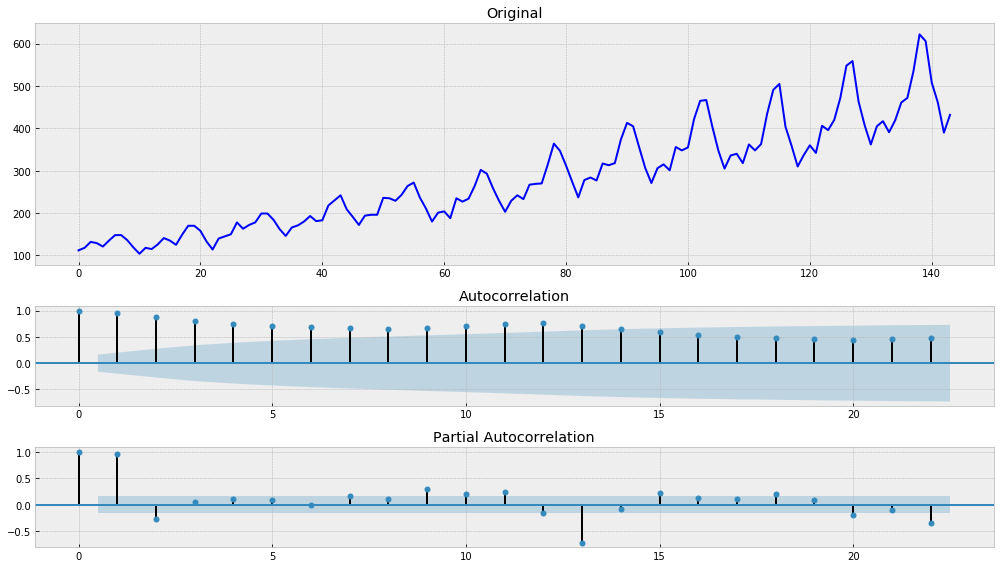

In [27]:
unstationary_series = list(all_series.values())[0]
tsplot(unstationary_series)

In [28]:
def stationate_series(series):    
    series = boxcox(series, 0)
    series = series[1:] - series[:-1]
    series = series[12:] - series[:-12]
    return series

**Стационарный ряд**

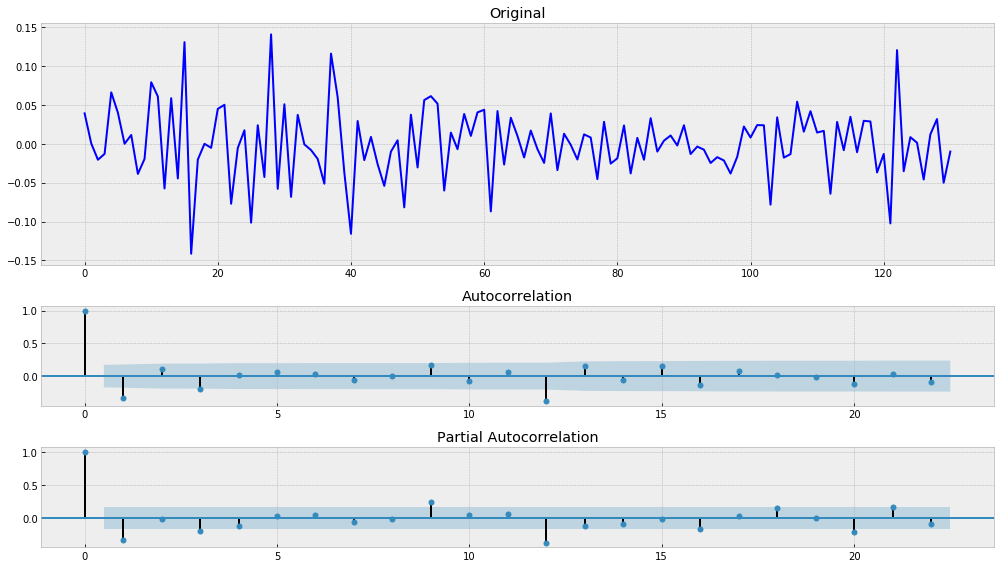

In [29]:
stationary_series = stationate_series(unstationary_series)
tsplot(stationary_series)

**Анализ методом скользящего среднего**

In [30]:
def moving_average(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()

In [45]:
def plot_ma(src, ma):
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(src, color='blue',label='original')
        plt.plot(ma, color='red', linewidth='4', label='Moving Average')
        plt.legend()

Нестационарный ряд

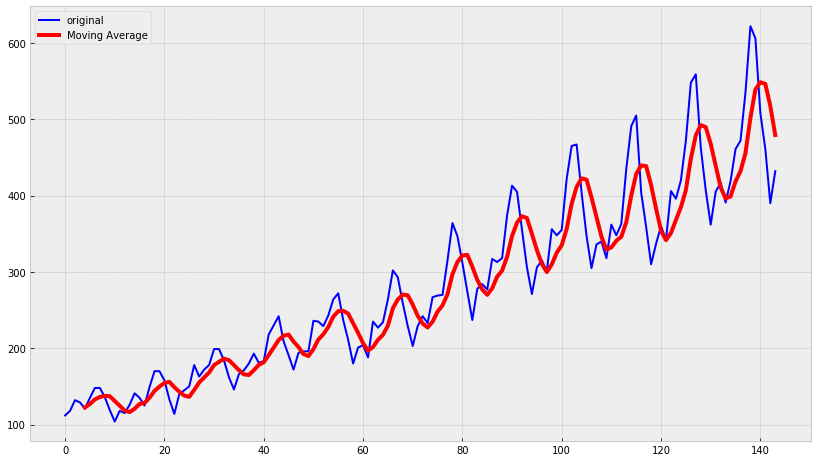

In [34]:
plot_ma(unstationary_series, moving_average(unstationary_series, 5))

Стационарный ряд

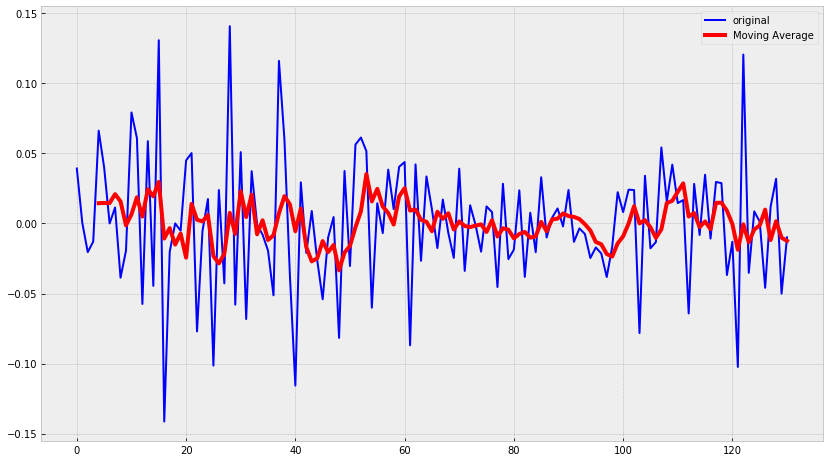

In [35]:
plot_ma(stationary_series, moving_average(stationary_series, 5))

**Анализ методом взвешенного скользящего среднего**

In [36]:
def weighted_moving_average(series, n, weights):
    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    wma = series.rolling(n).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)
    return wma

In [44]:
def plot_wma(src, ma, wma):
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(src, color='blue',label='original')
        plt.plot(ma, color='red', linewidth='2', label='MA')
        plt.plot(wma, color='green', linewidth='2', label='WMA')
        plt.legend()

Нестационарный ряд

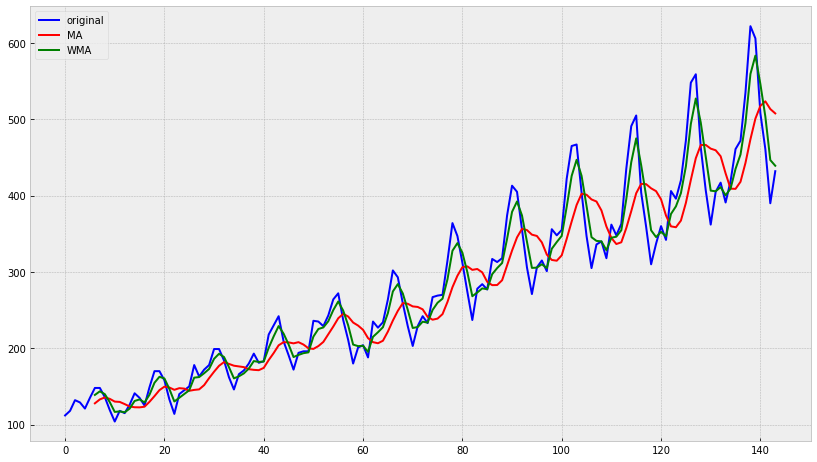

In [41]:
plot_wma(unstationary_series, 
        moving_average(unstationary_series, 7), 
        weighted_moving_average(unstationary_series, 7, [2**(i+1) for i in range(7)]))

Стационарный ряд

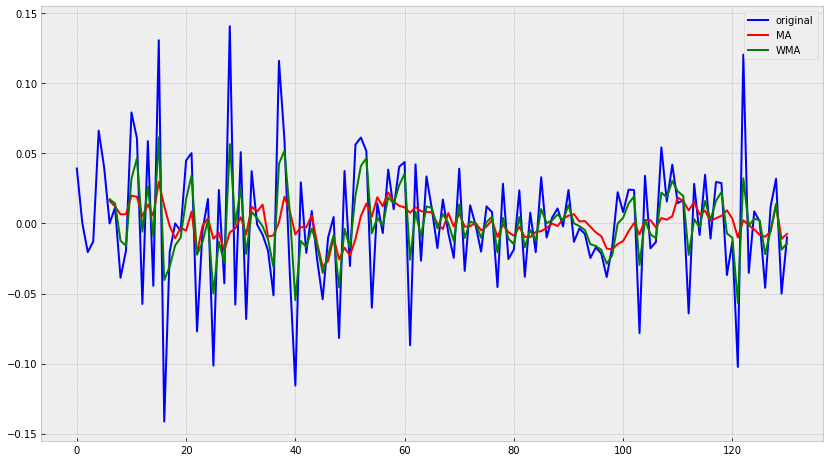

In [42]:
plot_wma(stationary_series, 
        moving_average(stationary_series, 7), 
        weighted_moving_average(stationary_series, 7, [2**(i+1) for i in range(7)]))

**Анализ методом экспоненциального сглаживания**

In [43]:
def exponential_moving_average(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

In [47]:
def plot_ema(src, ma, wma, ema):
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(src, color='blue',label='original')
        plt.plot(ma, color='red', linewidth='2', label='MA')
        plt.plot(wma, color='green', linewidth='2', label='WMA')
        plt.plot(ema, color='black', linewidth='4', label='EMA')
        plt.legend()

Нестационарный ряд

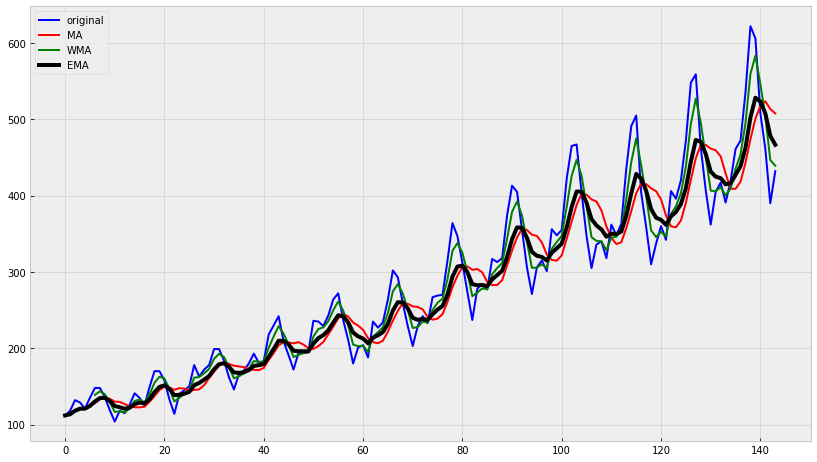

In [48]:
plot_ema(unstationary_series, 
        moving_average(unstationary_series, 7), 
        weighted_moving_average(unstationary_series, 7, [2**(i+1) for i in range(7)]),
        exponential_moving_average(unstationary_series, 0.25))

Стационарный ряд

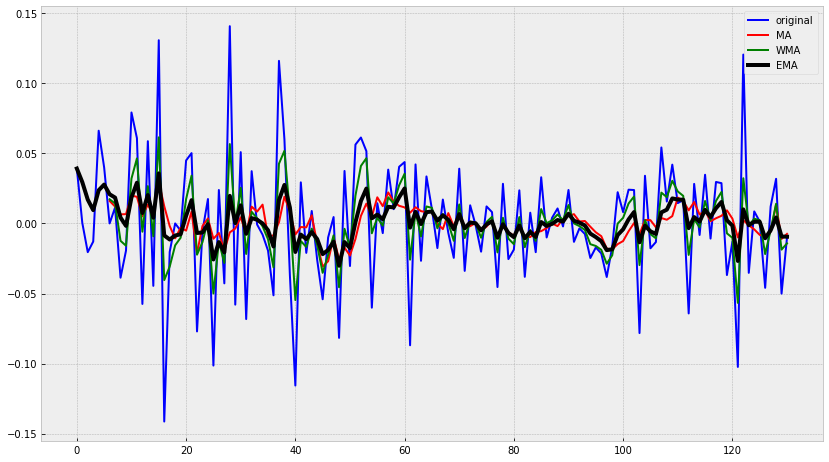

In [49]:
plot_ema(stationary_series, 
        moving_average(stationary_series, 7), 
        weighted_moving_average(stationary_series, 7, [2**(i+1) for i in range(7)]),
        exponential_moving_average(stationary_series, 0.25))

**Анализ методом двойного экспоненциального сглаживания**

In [50]:
def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

In [56]:
def plot_dema(src, alpha, beta):
    dema = double_ema(src, alpha, beta)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(src, color='blue',label='original')
        plt.plot(dema, color='red', linewidth='4', label='DEMA')
        plt.title("alpha={}, beta={}".format(alpha, beta))
        plt.legend()

Нестационарный ряд

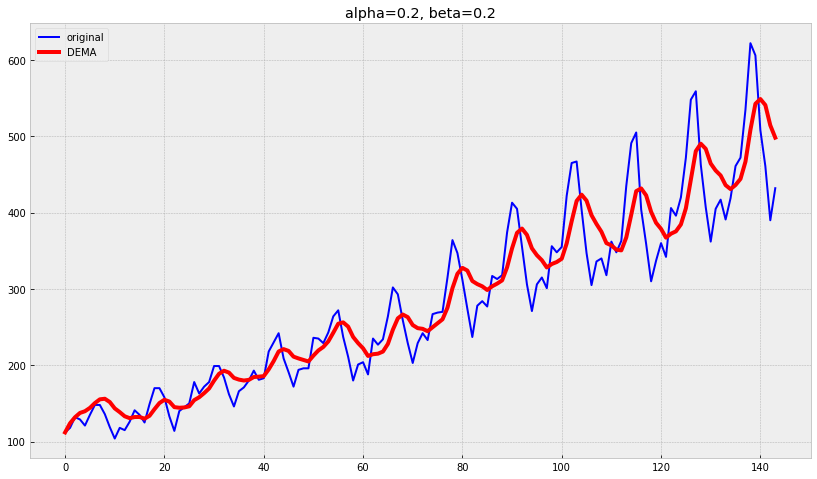

In [57]:
plot_dema(unstationary_series, 0.2, 0.2)

Стационарный ряд

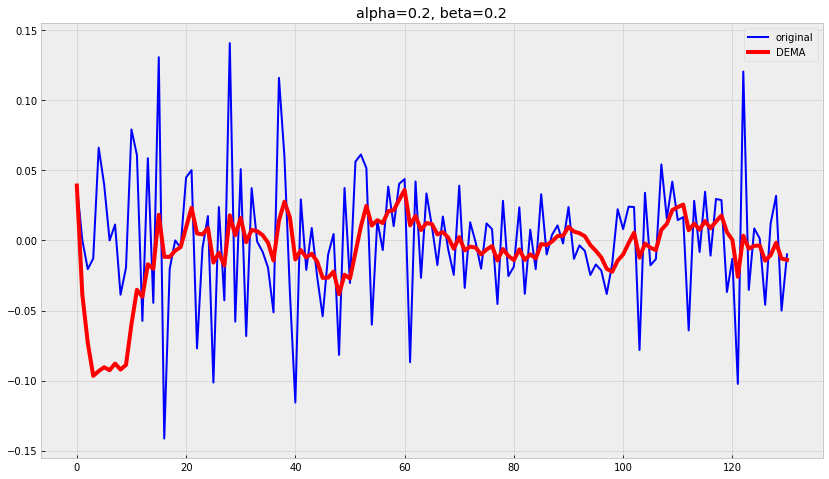

In [61]:
plot_dema(stationary_series, 0.2, 0.2)

**Анализ методом Хольта-Винтерса**

In [62]:
def initial_trend(series, season_len):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

In [63]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [64]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [80]:
def plot_tema(src, alpha, beta, gamma, ser_to_plot, n_preds=24):
    tema = triple_exponential_smoothing(src, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

Нестационарный ряд

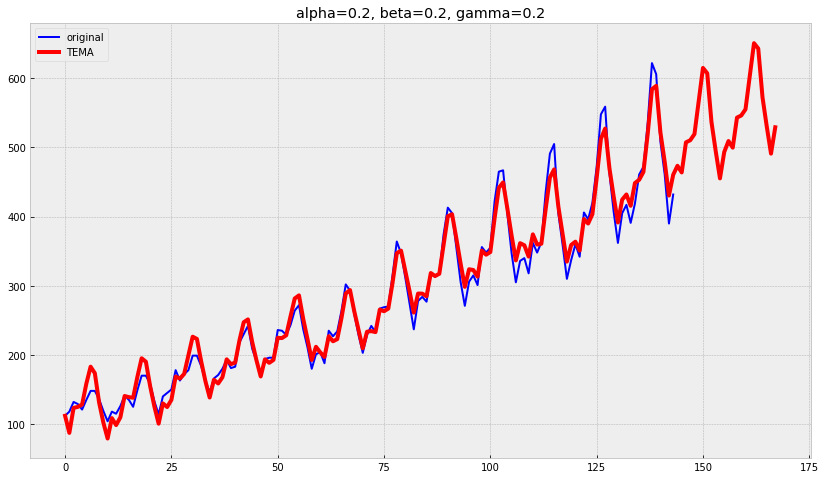

In [81]:
plot_tema(unstationary_series, 0.2, 0.2, 0.2, unstationary_series)

Стационарный ряд

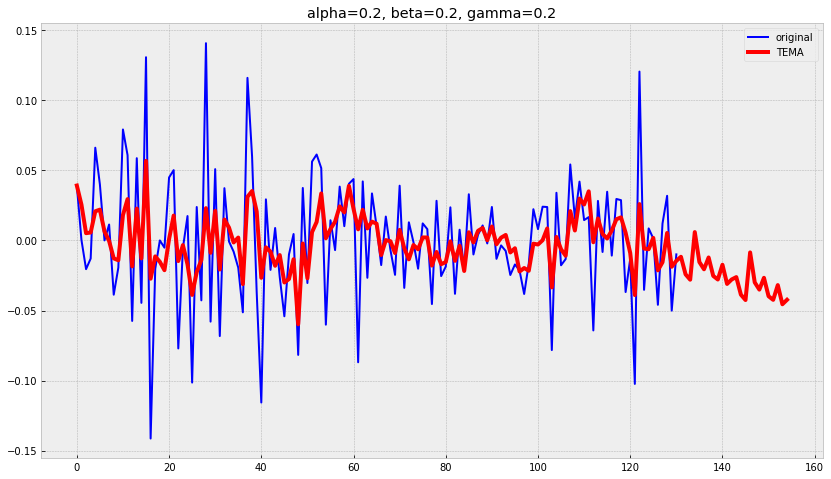

In [83]:
plot_tema(stationary_series, 0.2, 0.2, 0.2, stationary_series)

В ходе анализа исходных данных можно заметить, что модель, основанная на методе Хольта-Винтерса, дает наилучшее приближение в сравнении с другими методами. Это связано с тем, что, помимо уровня и тренда, она также учитывает сезонность. Конечно, она тоже неидеальна, т.к. не учитывает циклы и не нормализует дисперсию, но среди имеющихся все же являеся лучшей.